# Feature engineering

The conceptual framework was translated into concrete variables.

## Define aggregation levels and targets

The following target series were built.

1. System-level

   * y_daily_system: total daily trips across all stations.
   * y_hourly_system: total hourly trips.
   * Optional segmentation by day type (weekday vs weekend/holiday) was created for descriptive plots and model variants.

2. Station-level

   * y_hourly_station: hourly departures per station (start trips).
   * y_hourly_station_net: net change computed as departures minus arrivals for rebalancing analysis.
   * y_daily_station: daily totals per station.

3. Cluster-level

   * Stations were pre-clustered using k-means (or a comparable method) based on:

     * Tract-level demographics (density, income, employment)
     * Land-use mix and densities from PLUTO
     * Distance to the nearest subway and major transit hubs
   * Clusters were labeled as residential, commercial, or transport-adjacent.
   * y_hourly_cluster and y_daily_cluster were built from the cluster assignments.

Forecasting horizons were defined as follows.

* Short term: one-hour-ahead (t+1h) at the system, station, and cluster levels.
* Medium term: one-day-ahead (t+1 day) at the system level and, where applicable, the cluster level.

## Weather features

Weather features were created for each time index at both the system and station levels.

### Base features

The following base weather features were included.

* Air temperature
* Feels-like temperature
* Precipitation intensity and a precip_present binary flag
* Snow indicator (when present)
* Wind speed and humidity

### Transformations

The following transformations were applied.

* Temperature bands (for example: very cold, cold, moderate, hot, very hot)
* Quadratic or spline-like terms to capture non-linear effects, including a comfort-range response
* Lagged variables (for example: temp_t-1h and temp_t-24h) to represent behavioral inertia
* Rolling aggregates (for example: precipitation over the last 6 hours and rain over the last 3 days) to represent accumulated weather discomfort

### Spatial handling

Stations were assigned weather using the nearest weather station or a simple interpolation across the available reference points.

## Calendar and event features

Calendar and event features were constructed for each observation.

### Core calendar

The following calendar features were included.

* Hour of day encoded as cyclic features (sin/cos)
* Day of week encoded as one-hot indicators
* Week of year or month
* Weekend vs weekday flag
* Public holiday indicator

### Special periods

Pandemic regime indicators consistent with the study period were created.

* pre_covid (2019)
* covid (2020)
* recovery (2021–2023)

## Built environment and socio-demographics

Station-level static features were constructed by joining station locations to ACS, PLUTO, bike routes, and transit datasets.

### ACS-derived features

The following features were created from ACS.

* Population density
* Employment density
* Median income
* Modal share proxies when available (for example: share commuting by transit or bike)

### PLUTO and land-use features

The following features were created from PLUTO and land-use data.

* Land-use mix index around each station using an entropy-based index (residential, commercial, industrial, institutional)
* Floor area by use within a station buffer (for example: 300–500 m)
* Central business district vs outer borough indicator

### Bike route features

The following bike route features were created.

* Distance to the nearest bike route
* Total length of bike lanes within 500 m

## Contextual intensity features

Contextual intensity features were created for each station and time.

* AQI features included citywide and county-level daily AQI, along with flags for unhealthy days.
* Traffic and bicycle count features were included using the nearest sensor values or aggregated counts from nearby segments.

## Network and graph features

Network features were created based on a directed station graph.

* A directed graph was built where:

  * Nodes represent stations.
  * Edge weights represent average trip volume between station pairs over the training period.

Per-station network metrics were computed.

* Degree (in and out)
* Strength (weighted degree)
* Betweenness and closeness centrality where computationally feasible
* Egocentric metrics, including the share of trips with neighbors within a specified distance threshold

These network features were included as static inputs for Random Forest and XGBoost models and as station-level inputs for CNN-LSTM embeddings.

In [1]:
from __future__ import annotations

# Standard library
import os
from pathlib import Path

# Third-party libraries
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import shapely
from shapely.geometry import Point
from shapely.ops import nearest_points
from sklearn.cluster import KMeans
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score, silhouette_score)
from sklearn.preprocessing import StandardScaler

# Pandas display options
pd.set_option("display.max_columns", None)

In [2]:
# Paths
DATA_ROOT = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")
STATIONS_PATH = DATA_ROOT / "station" / "station_master.parquet"
ACS_PLUTO_TRACT_PATH = DATA_ROOT / "demographics" / "acs_pluto_tract_master.parquet"

# Load data
stations = pd.read_parquet(STATIONS_PATH)
acs_pluto_tract = pd.read_parquet(ACS_PLUTO_TRACT_PATH)

# Keep only real stations
stations_real = stations[stations["is_real_station"]].copy()

# Merge stations with tract-level ACS + PLUTO features
stations_merged = stations_real.merge(
    acs_pluto_tract,
    left_on="tract_geoid",
    right_on="geoid",
    how="left",
    suffixes=("", "_tract")
)

# Select the features used for clustering
feature_cols = [
    "avg_pct_residential",
    "avg_pct_commercial",
    "pct_transit_commute",
    "pop_density",
    "avg_far",
    "avg_units_density_per_10k_sqft"
]

missing_features = [c for c in feature_cols if c not in stations_merged.columns]
if missing_features:
    raise ValueError(f"Missing expected feature columns after merge: {missing_features}")

# Build station_features dataframe
station_features = stations_merged[["station_id", "station_name"] + feature_cols].copy()

# Drop rows with any missing feature values
station_features_clean = station_features.dropna(subset=feature_cols).reset_index(drop=True)

# Save station_ids for later alignment
station_ids_for_clustering = station_features_clean["station_id"].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(station_features_clean[feature_cols])

print("station_features_clean shape:", station_features_clean.shape)
station_features_clean.head()

station_features_clean shape: (3379, 8)


,station_id,station_name,avg_pct_residential,avg_pct_commercial,pct_transit_commute,pop_density,avg_far,avg_units_density_per_10k_sqft
0,116,W 17 St & 8 Ave,61.363179,40.411544,59.284333,0.002028,4.119681,35.664445
1,119,Park Ave & St Edwards St,42.847147,58.750151,66.666667,0.003404,2.313176,22.348888
2,120,Lexington Ave & Classon Ave,78.416940,14.549250,49.641731,0.003688,1.785808,17.194970
3,127,Barrow St & Hudson St,62.807305,37.390219,34.993447,0.001054,4.203836,20.970502
4,128,MacDougal St & Prince St,61.226494,36.604286,53.776824,0.000821,4.876329,30.793639


In [3]:
# Range of k to test
k_values = list(range(2, 11))

results = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20,
        max_iter=300,
    )
    labels = kmeans.fit_predict(X_scaled)
    
    # WCSS = inertia_ (sum of squared distances to centroids)
    wcss = kmeans.inertia_
    
    # Silhouette
    sil = silhouette_score(X_scaled, labels)
    
    # Calinski-Harabasz
    ch = calinski_harabasz_score(X_scaled, labels)
    
    # Davies-Bouldin
    db = davies_bouldin_score(X_scaled, labels)
    
    results.append({
        "k": k,
        "wcss": wcss,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
    })

metrics_df = pd.DataFrame(results)
metrics_df

,k,wcss,silhouette,calinski_harabasz,davies_bouldin
0,2,13981.955380,0.381809,1519.689779,1.300955
1,3,10816.211304,0.348542,1476.001797,1.181125
2,4,8765.172206,0.344816,1477.145111,1.093167
3,5,7754.956993,0.251078,1361.696382,1.142412
4,6,6990.304067,0.251368,1281.944418,1.230932
5,7,6288.379091,0.256848,1249.923713,1.176943
6,8,5811.674009,0.247709,1198.388447,1.185277
7,9,5378.070833,0.244331,1166.758556,1.154954
8,10,5121.071012,0.243071,1107.628932,1.143454


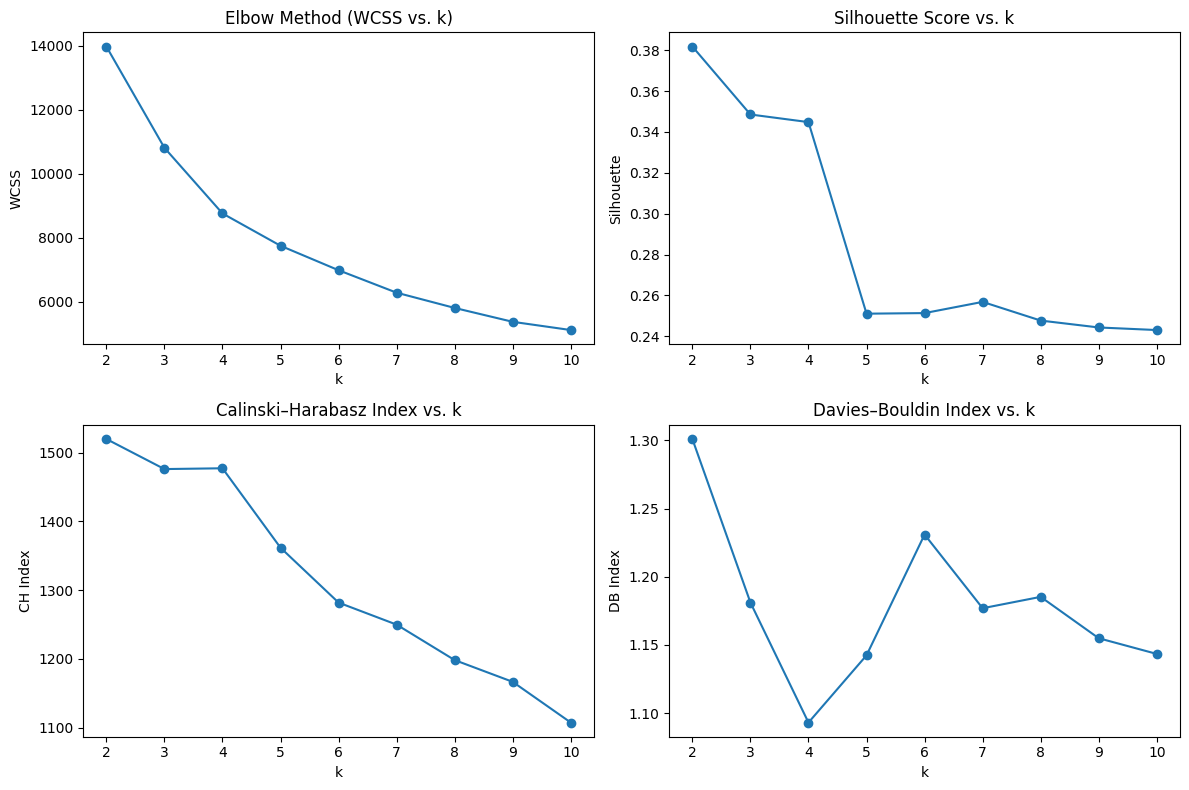

In [4]:
plt.figure(figsize=(12, 8))

# WCSS (elbow)
plt.subplot(2, 2, 1)
plt.plot(metrics_df["k"], metrics_df["wcss"], marker="o")
plt.title("Elbow Method (WCSS vs. k)")
plt.xlabel("k")
plt.ylabel("WCSS")
plt.xticks(metrics_df["k"])

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(metrics_df["k"], metrics_df["silhouette"], marker="o")
plt.title("Silhouette Score vs. k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.xticks(metrics_df["k"])

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(metrics_df["k"], metrics_df["calinski_harabasz"], marker="o")
plt.title("Calinski–Harabasz Index vs. k")
plt.xlabel("k")
plt.ylabel("CH Index")
plt.xticks(metrics_df["k"])

# Davies-Bouldin
plt.subplot(2, 2, 4)
plt.plot(metrics_df["k"], metrics_df["davies_bouldin"], marker="o")
plt.title("Davies–Bouldin Index vs. k")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.xticks(metrics_df["k"])

plt.tight_layout()
plt.show()

In [5]:
print("Top k by silhouette (descending):")
display(metrics_df.sort_values("silhouette", ascending=False).head())

print("\nTop k by Calinski–Harabasz (descending):")
display(metrics_df.sort_values("calinski_harabasz", ascending=False).head())

print("\nTop k by Davies–Bouldin (ascending):")
display(metrics_df.sort_values("davies_bouldin", ascending=True).head())

Top k by silhouette (descending):


,k,wcss,silhouette,calinski_harabasz,davies_bouldin
0,2,13981.955380,0.381809,1519.689779,1.300955
1,3,10816.211304,0.348542,1476.001797,1.181125
2,4,8765.172206,0.344816,1477.145111,1.093167
5,7,6288.379091,0.256848,1249.923713,1.176943
4,6,6990.304067,0.251368,1281.944418,1.230932



Top k by Calinski–Harabasz (descending):


,k,wcss,silhouette,calinski_harabasz,davies_bouldin
0,2,13981.955380,0.381809,1519.689779,1.300955
2,4,8765.172206,0.344816,1477.145111,1.093167
1,3,10816.211304,0.348542,1476.001797,1.181125
3,5,7754.956993,0.251078,1361.696382,1.142412
4,6,6990.304067,0.251368,1281.944418,1.230932



Top k by Davies–Bouldin (ascending):


,k,wcss,silhouette,calinski_harabasz,davies_bouldin
2,4,8765.172206,0.344816,1477.145111,1.093167
3,5,7754.956993,0.251078,1361.696382,1.142412
8,10,5121.071012,0.243071,1107.628932,1.143454
7,9,5378.070833,0.244331,1166.758556,1.154954
5,7,6288.379091,0.256848,1249.923713,1.176943


In [6]:
BASE = Path("/Users/zoltanjelovich/Documents/ISEG/MFW/data")

STATIONS_PATH          = BASE / "station" / "station_master.parquet"
CLUSTER_BASE           = BASE / "targets" / "cluster"
TARGETS_STATION_BASE   = BASE / "targets" / "station"

STATION_CLUSTERS_PATH  = CLUSTER_BASE / "station_clusters_k3.parquet"
HOURLY_CLUSTER_PATH    = CLUSTER_BASE / "y_hourly_cluster.parquet"
DAILY_CLUSTER_PATH     = CLUSTER_BASE / "y_daily_cluster.parquet"

print("Stations master:      ", STATIONS_PATH)
print("Station clusters:     ", STATION_CLUSTERS_PATH)
print("Hourly cluster series:", HOURLY_CLUSTER_PATH)
print("Daily cluster series: ", DAILY_CLUSTER_PATH)

stations          = pd.read_parquet(STATIONS_PATH)
station_clusters  = pd.read_parquet(STATION_CLUSTERS_PATH)
hourly_cluster    = pd.read_parquet(HOURLY_CLUSTER_PATH)
daily_cluster     = pd.read_parquet(DAILY_CLUSTER_PATH)

# Basic shapes
print("\nShapes:")
print("stations          :", stations.shape)
print("station_clusters  :", station_clusters.shape)
print("hourly_cluster    :", hourly_cluster.shape)
print("daily_cluster     :", daily_cluster.shape)

station_clusters.head(), hourly_cluster.head(), daily_cluster.head()

Stations master:       /Users/zoltanjelovich/Documents/ISEG/MFW/data/station/station_master.parquet
Station clusters:      /Users/zoltanjelovich/Documents/ISEG/MFW/data/targets/cluster/station_clusters_k3.parquet
Hourly cluster series: /Users/zoltanjelovich/Documents/ISEG/MFW/data/targets/cluster/y_hourly_cluster.parquet
Daily cluster series:  /Users/zoltanjelovich/Documents/ISEG/MFW/data/targets/cluster/y_daily_cluster.parquet

Shapes:
stations          : (3652, 77)
station_clusters  : (3602, 4)
hourly_cluster    : (187275, 13)
daily_cluster     : (7836, 9)


(  station_id                 station_name  cluster_id cluster_label
 0        116              W 17 St & 8 Ave           1    commercial
 1        119     Park Ave & St Edwards St           0   residential
 2        120  Lexington Ave & Classon Ave           0   residential
 3        127        Barrow St & Hudson St           1    commercial
 4        128     MacDougal St & Prince St           1    commercial,
               ts_hour  cluster_id     cluster_label  departures  arrivals  \
 0 2017-01-01 00:00:00           0       residential          74        57   
 1 2017-01-01 00:00:00           1        commercial         275       179   
 2 2017-01-01 00:00:00           2  transit_adjacent           1         0   
 3 2017-01-01 01:00:00           0       residential          61        76   
 4 2017-01-01 01:00:00           1        commercial         289       317   
 
    net       date  year  month  day  hour  dow  is_weekend  
 0   17 2017-01-01  2017      1    1     0    6      

In [7]:
# Ensure station_id types line up
stations["station_id"]         = stations["station_id"].astype(str)
station_clusters["station_id"] = station_clusters["station_id"].astype(str)

# Merge clusters with station metadata for borough info
station_clusters_ext = station_clusters.merge(
    stations[["station_id", "borough_name"]],
    on="station_id",
    how="left",
)

# Overall counts and shares
cluster_counts = (
    station_clusters_ext["cluster_label"]
    .value_counts()
    .rename("count")
    .to_frame()
)

cluster_counts["share"] = (
    cluster_counts["count"] / cluster_counts["count"].sum()
)

print("Cluster composition (stations):")
display(cluster_counts)

# Borough x cluster cross-tab
borough_cluster_ct = pd.crosstab(
    station_clusters_ext["borough_name"],
    station_clusters_ext["cluster_label"],
    normalize="index"
).round(3)

print("\nCluster distribution within each borough (row = borough, values = share):")
display(borough_cluster_ct)

Cluster composition (stations):


,count,share
cluster_label,,
commercial,1460,0.405330
residential,1155,0.320655
transit_adjacent,987,0.274014



Cluster distribution within each borough (row = borough, values = share):


cluster_label,commercial,residential,transit_adjacent
borough_name,,,
Bronx,0.000,0.000,1.000
Brooklyn,0.015,0.985,0.000
Manhattan,0.974,0.000,0.026
Queens,0.012,0.000,0.988
Staten Island,1.000,0.000,0.000


In [8]:
# Basic coverage
date_min = daily_cluster["date"].min()
date_max = daily_cluster["date"].max()
print(f"Daily cluster series coverage: {date_min.date()} to {date_max.date()}")

# Total departures by cluster over entire period
daily_totals = (
    daily_cluster
    .groupby("cluster_label", as_index=False)["departures"]
    .sum()
    .rename(columns={"departures": "total_departures"})
)

daily_totals["share_of_total"] = (
    daily_totals["total_departures"] / daily_totals["total_departures"].sum()
)

print("\nDaily departures by cluster over full period:")
display(daily_totals)

# Per-cluster min/max daily demand
daily_stats = (
    daily_cluster
    .groupby("cluster_label")["departures"]
    .describe()[["min", "25%", "50%", "75%", "max", "mean"]]
    .round(1)
)

print("\nDistribution of daily departures per cluster:")
display(daily_stats)

Daily cluster series coverage: 2017-01-01 to 2024-12-31

Daily departures by cluster over full period:


,cluster_label,total_departures,share_of_total
0,commercial,137941618,0.713515
1,residential,41585479,0.215105
2,transit_adjacent,13799765,0.071380



Distribution of daily departures per cluster:


,min,25%,50%,75%,max,mean
cluster_label,,,,,,
commercial,131.0,33254.5,51433.0,69736.2,125592.0,52810.7
residential,27.0,7998.2,13180.0,22015.2,55038.0,15920.9
transit_adjacent,14.0,1252.2,3832.5,8051.5,19569.0,5283.2


In [9]:
ts_min = hourly_cluster["ts_hour"].min()
ts_max = hourly_cluster["ts_hour"].max()
print(f"Hourly cluster series coverage: {ts_min} to {ts_max}")

# Total departures by cluster over entire period
hourly_totals = (
    hourly_cluster
    .groupby("cluster_label", as_index=False)["departures"]
    .sum()
    .rename(columns={"departures": "total_departures"})
)

hourly_totals["share_of_total"] = (
    hourly_totals["total_departures"] / hourly_totals["total_departures"].sum()
)

print("\nHourly departures by cluster over full period:")
display(hourly_totals)

# Typical hourly demand profile (average over full period)
hourly_profile = (
    hourly_cluster
    .groupby(["hour", "cluster_label"], as_index=False)["departures"]
    .mean()
    .rename(columns={"departures": "avg_departures"})
)

print("\nAverage hourly departures by cluster (all years combined):")
hourly_profile.head(12)

Hourly cluster series coverage: 2017-01-01 00:00:00 to 2024-12-31 23:00:00

Hourly departures by cluster over full period:


,cluster_label,total_departures,share_of_total
0,commercial,137941618,0.713515
1,residential,41585479,0.215105
2,transit_adjacent,13799765,0.071380



Average hourly departures by cluster (all years combined):


,hour,cluster_label,avg_departures
0,0,commercial,601.793183
1,0,residential,244.682515
2,0,transit_adjacent,84.569225
3,1,commercial,364.056748
4,1,residential,146.983493
5,1,transit_adjacent,51.498433
6,2,commercial,232.088530
7,2,residential,92.956823
8,2,transit_adjacent,34.274329
9,3,commercial,147.457965
